In [4]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
from torchvision import datasets, transforms
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/5], Loss: {running_loss/len(trainloader):.4f}')

# optionally save checkpoint if you want
torch.save(model.state_dict(), "simple_mnist_cnn.pth")


Epoch [1/5], Loss: 0.1661
Epoch [2/5], Loss: 0.0470
Epoch [3/5], Loss: 0.0281
Epoch [4/5], Loss: 0.0185
Epoch [5/5], Loss: 0.0140


In [42]:
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

images, labels = next(iter(testloader))
image = images[0].numpy().squeeze()
label = labels[0]
print(f"True label: {label}")


True label: 6


In [43]:
def predict(images_np):
    model.eval()
    # collapse RGB to grayscale (taking just one channel)
    images_np = images_np[:,:,:,0:1]  # shape (n_samples, 28,28,1)
    images_tensor = torch.tensor(images_np).permute(0, 3, 1, 2).float()
    with torch.no_grad():
        logits = model(images_tensor.to(device))
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()


100%|██████████| 1000/1000 [00:01<00:00, 676.55it/s]


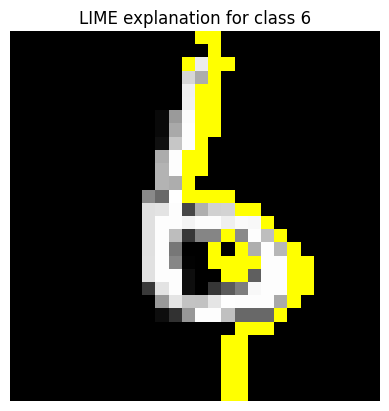

In [44]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=image,
    classifier_fn=predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

top_class = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_class,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title(f"LIME explanation for class {top_class}")
plt.axis("off")
plt.show()

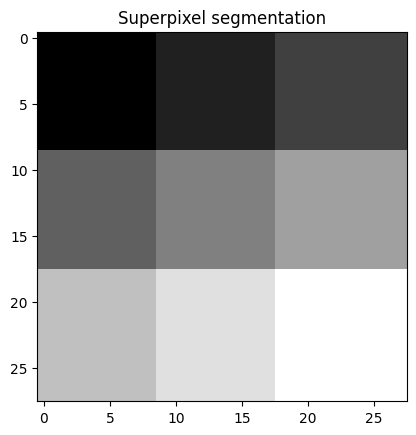

In [23]:
from skimage.segmentation import slic
import matplotlib.pyplot as plt

segments = slic(image, n_segments=10, compactness=10, channel_axis=None)
plt.imshow(segments, cmap='gray')
plt.title("Superpixel segmentation")
plt.show()

Selected image with label: 4


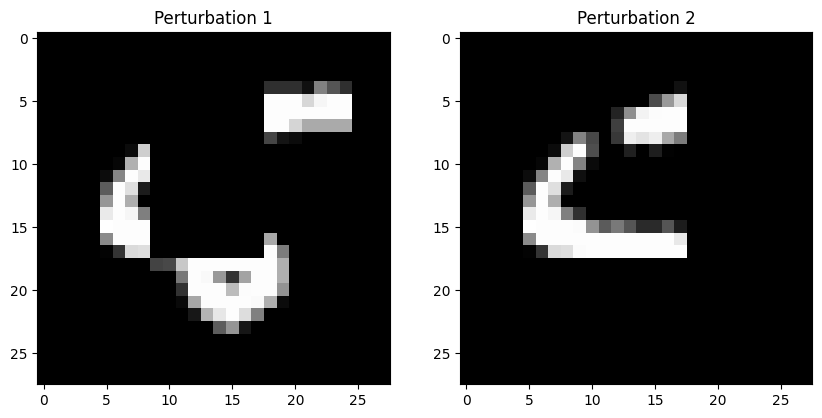

In [20]:
import numpy as np

def get_image_by_label(target_label):
    for img, lbl in testset:
        if lbl == target_label:
            return img.numpy().squeeze(), lbl
    raise ValueError(f"No image found with label {target_label}")

print("Selected image with label:", label)

target_digit = 5 
image, label = get_image_by_label(target_digit)

def apply_mask(image, segments, mask, hide_color=0):
    perturbed = image.copy()
    for i, keep in enumerate(mask):
        if keep == 0:
            perturbed[segments == i] = hide_color
    return perturbed

mask1 = [1,0,0,1,1,0,1,0,1,1]
mask2 = [0,1,1,0,1,1,0,1,0,0]

perturbed1 = apply_mask(image, segments, mask1)
perturbed2 = apply_mask(image, segments, mask2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(perturbed1, cmap='gray')
plt.title("Perturbation 1")
plt.subplot(1,2,2)
plt.imshow(perturbed2, cmap='gray')
plt.title("Perturbation 2")
plt.show()


In [21]:
perturbed_batch = np.stack([perturbed1, perturbed2], axis=0)[..., np.newaxis]
print(perturbed_batch.shape)

(2, 28, 28, 1)


In [24]:
probs = predict(perturbed_batch)
pred1 = np.argmax(probs[0])
pred2 = np.argmax(probs[1])

print("Predicted class for Perturbation 1:", pred1)
print("Predicted class for Perturbation 2:", pred2)

Predicted class for Perturbation 1: 6
Predicted class for Perturbation 2: 5
